### Required Libraries

In [33]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import random
import math
import pickle
import seaborn as sns
from imblearn.over_sampling import SMOTE
import statsmodels.api as sm
from statsmodels.api import Logit
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, confusion_matrix, accuracy_score

### Preprocessed Dataset

In [34]:
# dataset path
datasetPath = './DataSets/preprocessedData.csv'

# calling the dataset
df = pd.read_csv(datasetPath)
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Satisfaction Score,Point Earned,Geography_Germany,Geography_Spain,Gender_Male,HasCrCard_1,IsActiveMember_1,Complain_1,Card Type_GOLD,Card Type_PLATINUM,Card Type_SILVER,Exited
0,-0.326221,0.293517,-1.041760,-1.225848,-0.911583,0.021886,-0.721130,-0.630839,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1
1,-0.440036,0.198164,-1.387538,0.117350,-0.911583,0.216534,-0.009816,-0.666251,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0
2,-1.536794,0.293517,1.032908,1.333053,2.527057,0.240687,-0.009816,-1.015942,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1
3,0.501521,0.007457,-1.387538,-1.225848,0.807737,-0.108918,1.412812,-1.135457,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,2.063884,0.388871,-1.041760,0.785728,-0.911583,-0.365276,1.412812,-0.803472,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0


In [35]:
num_col = list(df.columns[:8])

### Building X and y

In [36]:
# seperating X and y
y = df[['Exited']]
X = df.drop(['Exited'], axis=1)

 ### Ensuring Balance

In [37]:
# resampling to ensure balance
resampler = SMOTE(random_state=26)

X_bal, y_bal = resampler.fit_resample(X, y)
X_bal = sm.add_constant(X_bal)

In [38]:
y_bal.value_counts()

Exited
0         7645
1         7645
Name: count, dtype: int64

### Logistic Regression

In [39]:
# train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_bal, y_bal, test_size=0.2, random_state=103)

In [40]:
# Logistic model building
model = sm.Logit(y_train, X_train)
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.007137
         Iterations 13


In [41]:
# model summary
colnames = pd.DataFrame(result.summary().tables[1]).loc[0,]
coefDf = pd.DataFrame(result.summary().tables[1], columns=colnames).drop(0, axis=0).reset_index().drop('index', axis=1)
coefDf.to_csv('./DataSets/coefDf.csv', index=False)
coefDf

,,coef,std err,z,P>|z|,[0.025,0.975]
0,const,-6.4636,0.947,-6.826,0.000,-8.319,-4.608
1,CreditScore,0.1188,0.290,0.409,0.682,-0.450,0.688
2,Age,1.5458,0.342,4.524,0.000,0.876,2.216
3,Tenure,-0.1941,0.278,-0.697,0.486,-0.740,0.352
4,Balance,0.1918,0.321,0.598,0.550,-0.437,0.820
5,NumOfProducts,-0.4355,0.223,-1.951,0.051,-0.873,0.002
6,EstimatedSalary,0.0179,0.271,0.066,0.947,-0.514,0.550
7,Satisfaction Score,-0.3589,0.277,-1.295,0.195,-0.902,0.184
8,Point Earned,-0.6975,0.303,-2.301,0.021,-1.292,-0.103
9,Geography_Germany,-1.1005,0.743,-1.482,0.138,-2.556,0.355


In [42]:
# prediction probability
pred_proba = result.predict(X_test)

# best threshold
fpr, tpr, threshold = roc_curve(y_test, pred_proba)
bestThresh = threshold[np.argmax(tpr*(1-fpr))]
print(bestThresh)

# predicted outcome
y_pred = np.array([1 if x>bestThresh else 0 for x in pred_proba])

0.8588197363814101


In [52]:
# saving the threshold
with open('./pickleFiles/threshold.pkl', 'wb') as file:
    pickle.dump(bestThresh, file)

In [43]:
# function for k-fold cross-validation technique
def kfoldCV(X, y, k=5):
    '''function to cross validate the model to get an idea about the test accuracy'''
    # shapes
    n = X_bal.shape[0]
    id = random.sample(range(n), n)
    k1 = math.floor(len(id)/k)

    accScore = []
    for i in range(k):
        # train-test split
        testid = id[i*k1:(i+1)*k1]
        X_test = X.loc[testid, ]
        y_test = y.loc[testid, ]
        X_train = X.drop(testid, axis=0)
        y_train = y.drop(testid, axis=0)

        # model building
        model = sm.Logit(y_train, X_train)
        result = model.fit(disp=False)
        pred_proba = result.predict(X_test)

        # choosing the best threshold
        fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
        best_threshold = thresholds[np.argmax(tpr*(1-fpr))]
        y_pred = [1 if x>best_threshold else 0 for x in pred_proba]

        # storing the accuracy 
        accScore.append(accuracy_score(y_test, y_pred))
    return accScore

In [44]:
# test accuracies for a k-fold cross validation
cvTestAccValues = kfoldCV(X_bal, y_bal, k=10)
averageAcc = np.mean(np.array(cvTestAccValues))
print(f'Test Accuracies: \n{[round(x, 5) for x in cvTestAccValues]}')
print(f'Average Test Accuracy: \n{round(averageAcc, 5)}')

Test Accuracies: 
[0.99738, 0.99869, 0.99869, 0.99935, 0.99738, 0.99804, 0.99869, 0.99738, 0.99869, 0.99869]
Average Test Accuracy: 
0.9983


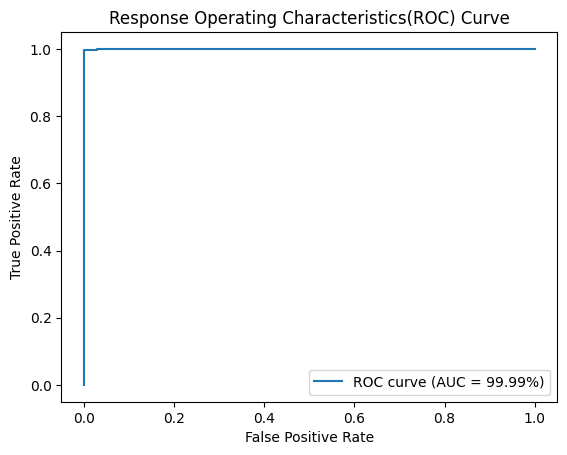

In [45]:
# roc curve
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {round(100*roc_auc_score(y_test, pred_proba),2)}%)")
plt.xlabel('False Positive Rate')
plt.ylabel("True Positive Rate")
plt.title("Response Operating Characteristics(ROC) Curve")
plt.legend()

In [46]:
# classification report
cr = classification_report(y_test, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1528
           1       1.00      1.00      1.00      1530

    accuracy                           1.00      3058
   macro avg       1.00      1.00      1.00      3058
weighted avg       1.00      1.00      1.00      3058



Text(0.5, 1.0, 'Heatmap of the confusion matrix')

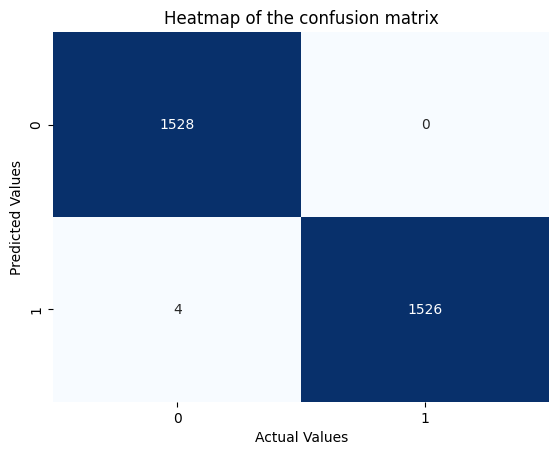

In [47]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='g', 
            cmap="Blues", cbar=False)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Heatmap of the confusion matrix")

In [48]:
# accuracy
round(accuracy_score(y_test, y_pred)*100, 2)

99.87

### Saving the model

In [49]:
with open('./pickleFiles/logitModel.pkl', "wb") as file:
    pickle.dump(result, file)